In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/MyDrive/

/content/drive/MyDrive


In [4]:
post_flood = "Hanumannagar_Postflood_Orthomosaic.tif"
pre_flood = "Hanumannagar_Preflood_Orthomosaic.tif"



In [5]:
!pip install rasterio

In [6]:
import rasterio

with rasterio.open(pre_flood) as src:
    print("PRE:")
    print("Size (W,H):", src.width, src.height)
    print("Bands:", src.count)
    print("CRS:", src.crs)
    print("Transform:", src.transform)

with rasterio.open(post_flood) as src:
    print("POST:")
    print("Size (W,H):", src.width, src.height)
    print("Bands:", src.count)
    print("CRS:", src.crs)
    print("Transform:", src.transform)

PRE:
Size (W,H): 60971 88127
Bands: 4
CRS: EPSG:32645
Transform: | 0.04, 0.00, 489356.81|
| 0.00,-0.04, 2939440.70|
| 0.00, 0.00, 1.00|
POST:
Size (W,H): 70101 103761
Bands: 4
CRS: EPSG:32645
Transform: | 0.04, 0.00, 489425.93|
| 0.00,-0.04, 2939394.83|
| 0.00, 0.00, 1.00|


In [7]:
with rasterio.open(pre_flood) as src:
    transform = src.transform
    print("Transform:", transform)
    pixel_width = transform[0]
    pixel_height = transform[4]
    pixel_area_m2 = abs(pixel_width * pixel_height)
    print("Pixel width (m):", pixel_width)
    print("Pixel height (m):", pixel_height)
    print("Pixel area (m^2):", pixel_area_m2)

Transform: | 0.04, 0.00, 489356.81|
| 0.00,-0.04, 2939440.70|
| 0.00, 0.00, 1.00|
Pixel width (m): 0.04312250000000027
Pixel height (m): -0.04312249999999988
Pixel area (m^2): 0.0018595500062500068


In [13]:
from rasterio.windows import Window
src = rasterio.open(pre_flood)
tile_size = 1024

W, H = src.width, src.height


row_off = H//2
col_off = W//2
w = min(tile_size, W - col_off)
h = min(tile_size, H - row_off)

window = Window(col_off, row_off, w, h)
print("Window:", window)


Window: Window(col_off=30485, row_off=44063, width=1024, height=1024)


In [14]:
tile = src.read(window=window)
print("Tile shape:", tile.shape)


Tile shape: (4, 1024, 1024)


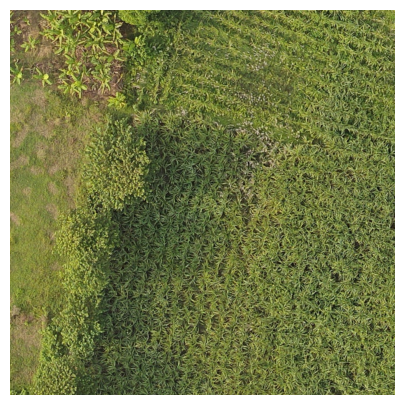

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Take first 3 bands as RGB
rgb = tile[:3, :, :]        # (3, H, W)
rgb = np.moveaxis(rgb, 0, -1)  # -> (H, W, 3)

# Simple normalization to 0–1
rgb = rgb.astype("float32")
rgb = rgb / rgb.max()

plt.figure(figsize=(5, 5))
plt.imshow(rgb)
plt.axis("off")
plt.show()


In [16]:
!pip install pyproj

In [17]:
tile_size = 1024
W, H = src.width, src.height

# same center tile we used before
row_off = H // 2
col_off = W // 2
w = min(tile_size, W - col_off)
h = min(tile_size, H - row_off)

window = Window(col_off, row_off, w, h)

transform = src.transform
print("Image CRS:", src.crs)
print("Window:", window)

Image CRS: EPSG:32645
Window: Window(col_off=30485, row_off=44063, width=1024, height=1024)


In [18]:
import rasterio.transform


row_center = row_off + h / 2
col_center = col_off + w / 2

x_center, y_center = rasterio.transform.xy(
    transform,
    row_center,
    col_center,
    offset="center"
)

print("Center (x, y) in EPSG:32645:", x_center, y_center)


Center (x, y) in EPSG:32645: 490693.5021524106 2937518.4927018783


In [19]:
from pyproj import Transformer

with rasterio.open(pre_flood) as src:
    tile_size = 1024
    W, H = src.width, src.height

    row_off = H // 2
    col_off = W // 2
    w = min(tile_size, W - col_off)
    h = min(tile_size, H - row_off)

    window = Window(col_off, row_off, w, h)
    transform = src.transform

    row_center = row_off + h / 2
    col_center = col_off + w / 2

    x_center, y_center = rasterio.transform.xy(
        transform,
        row_center,
        col_center,
        offset="center"
    )

    # Set up transformer: from image CRS -> WGS84 (EPSG:4326)
    transformer = Transformer.from_crs(src.crs, "EPSG:4326", always_xy=True)
    lon_center, lat_center = transformer.transform(x_center, y_center)

    print("Center (x, y) in EPSG:32645:", x_center, y_center)
    print("Center (lon, lat) in WGS84:", lon_center, lat_center)


Center (x, y) in EPSG:32645: 490693.5021524106 2937518.4927018783
Center (lon, lat) in WGS84: 86.90656117641177 26.558306023517396


In [20]:
post_flood = "Hanumannagar_Postflood_Orthomosaic.tif"

with rasterio.open(post_flood) as src_post:
    tile_size = 1024
    Wp, Hp = src_post.width, src_post.height
    print("POST size:", Wp, Hp)

    # center tile (post-flood)
    row_off_p = Hp // 2
    col_off_p = Wp // 2
    w_p = min(tile_size, Wp - col_off_p)
    h_p = min(tile_size, Hp - row_off_p)

    window_p = Window(col_off_p, row_off_p, w_p, h_p)
    post_tile = src_post.read(window=window_p)  # (bands, h, w)
    print("Post tile shape:", post_tile.shape)
    print("dtype:", post_tile.dtype)
    print("Band 1 min/max:", post_tile[0].min(), post_tile[0].max())
    print("Band 2 min/max:", post_tile[1].min(), post_tile[1].max())
    print("Band 3 min/max:", post_tile[2].min(), post_tile[2].max())
    if src_post.count >= 4:
        print("Band 4 min/max:", post_tile[3].min(), post_tile[3].max())

POST size: 70101 103761
Post tile shape: (4, 1024, 1024)
dtype: uint8
Band 1 min/max: 28 252
Band 2 min/max: 43 250
Band 3 min/max: 29 239
Band 4 min/max: 255 255


In [22]:
def compute_water_mask(tile, use_nir=True, ndwi_thresh=0.1, min_intensity=20):

    tile = tile.astype("float32")
    R = tile[0]
    G = tile[1]
    B = tile[2]

    if use_nir and tile.shape[0] >= 4:
        NIR = tile[3]
        ndwi = (G - NIR) / (G + NIR + 1e-6)
    else:
        ndwi = (G - R) / (G + R + 1e-6)


    intensity = (R + G + B) / 3.0
    water_mask = (ndwi > ndwi_thresh) & (intensity > min_intensity)

    return water_mask, ndwi

Water pixels: 102


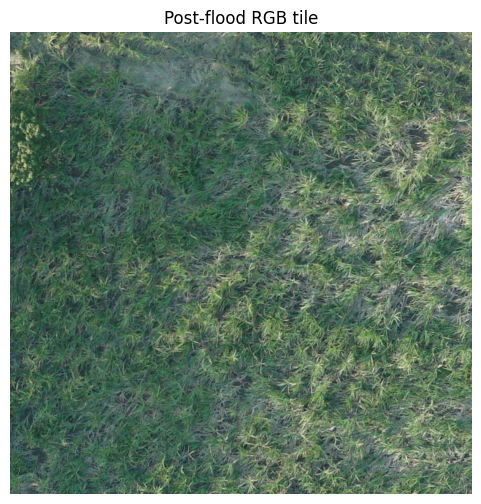

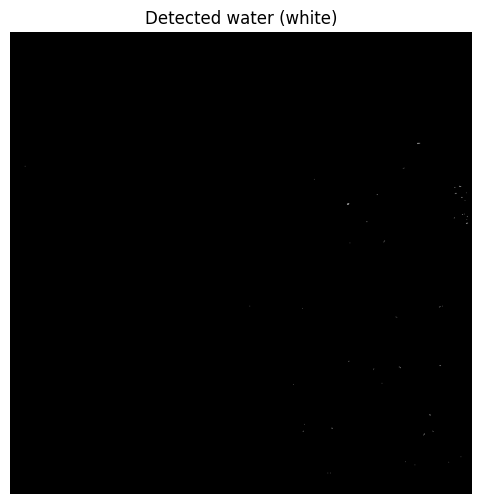

In [25]:
import matplotlib.pyplot as plt

# Compute water mask
water_mask, ndwi = compute_water_mask(post_tile, use_nir=True, ndwi_thresh=-0.05, min_intensity=20)

print("Water pixels:", np.count_nonzero(water_mask))

# Prepare RGB for display
rgb_post = post_tile[:3].astype("float32")
valid = rgb_post > 0
if valid.any():
    vmin = rgb_post[valid].min()
    vmax = rgb_post[valid].max()
    rgb_post = (rgb_post - vmin) / (vmax - vmin + 1e-6)
else:
    rgb_post[:] = 0

rgb_post = np.moveaxis(rgb_post, 0, -1)  # (H, W, 3)

# Show original tile
plt.figure(figsize=(6, 6))
plt.imshow(rgb_post)
plt.title("Post-flood RGB tile")
plt.axis("off")
plt.show()

# Show water mask
plt.figure(figsize=(6, 6))
plt.imshow(water_mask, cmap="gray")
plt.title("Detected water (white)")
plt.axis("off")
plt.show()


In [26]:


tile_size = 1024  # pixels

with rasterio.open(pre_flood) as src_pre, rasterio.open(post_flood) as src_post:
    print("PRE size:", src_pre.width, src_pre.height)
    print("POST size:", src_post.width, src_post.height)

    # 1) Pick a center tile in PRE
    W_pre, H_pre = src_pre.width, src_pre.height
    row_off_pre = H_pre // 2
    col_off_pre = W_pre // 2
    w_pre = min(tile_size, W_pre - col_off_pre)
    h_pre = min(tile_size, H_pre - row_off_pre)

    pre_window = Window(col_off_pre, row_off_pre, w_pre, h_pre)
    print("PRE window:", pre_window)

    # 2) Get its bounds (in EPSG:32645 meters)
    pre_bounds = rasterio.windows.bounds(pre_window, src_pre.transform)
    print("PRE window bounds (left, bottom, right, top):", pre_bounds)

    # 3) Use the same bounds to compute a window in POST
    post_window_float = rasterio.windows.from_bounds(
        *pre_bounds,
        transform=src_post.transform
    )
    print("POST window (float):", post_window_float)

    # 4) Round to integer pixel offsets/sizes
    post_window = Window(
        col_off=int(round(post_window_float.col_off)),
        row_off=int(round(post_window_float.row_off)),
        width=int(round(post_window_float.width)),
        height=int(round(post_window_float.height)),
    )
    print("POST window (int):", post_window)

    # 5) Read both tiles
    pre_tile = src_pre.read(window=pre_window)   # (bands, h1, w1)
    post_tile = src_post.read(window=post_window)  # (bands, h2, w2)

    print("pre_tile shape:", pre_tile.shape)
    print("post_tile shape:", post_tile.shape)


PRE size: 60971 88127
POST size: 70101 103761
PRE window: Window(col_off=30485, row_off=44063, width=1024, height=1024)
PRE window bounds (left, bottom, right, top): (490671.40187116066, 2937496.4355431283, 490715.55931116064, 2937540.5929831285)
POST window (float): Window(col_off=np.float64(34671.93396839313), row_off=np.float64(51618.87258164585), width=np.float64(1229.269216099754), height=np.float64(1229.269216105342))
POST window (int): Window(col_off=34672, row_off=51619, width=1229, height=1229)
pre_tile shape: (4, 1024, 1024)
post_tile shape: (4, 1229, 1229)


In [27]:
import numpy as np

_, h_pre, w_pre = pre_tile.shape
_, h_post, w_post = post_tile.shape

h = min(h_pre, h_post)
w = min(w_pre, w_post)

pre_tile = pre_tile[:, :h, :w]
post_tile = post_tile[:, :h, :w]

print("Aligned pre_tile:", pre_tile.shape)
print("Aligned post_tile:", post_tile.shape)


Aligned pre_tile: (4, 1024, 1024)
Aligned post_tile: (4, 1024, 1024)


In [28]:
# For PRE tile (before flood)
pre_water, pre_ndwi = compute_water_mask(pre_tile, use_nir=True, ndwi_thresh=0.1, min_intensity=20)

# For POST tile (after flood)
post_water, post_ndwi = compute_water_mask(post_tile, use_nir=True, ndwi_thresh=0.1, min_intensity=20)

print("Pre water pixels:", np.count_nonzero(pre_water))
print("Post water pixels:", np.count_nonzero(post_water))


Pre water pixels: 0
Post water pixels: 0


In [29]:
pre_land = ~pre_water
lost_land_mask = pre_land & post_water
print("Lost land pixels:", np.count_nonzero(lost_land_mask))


Lost land pixels: 0


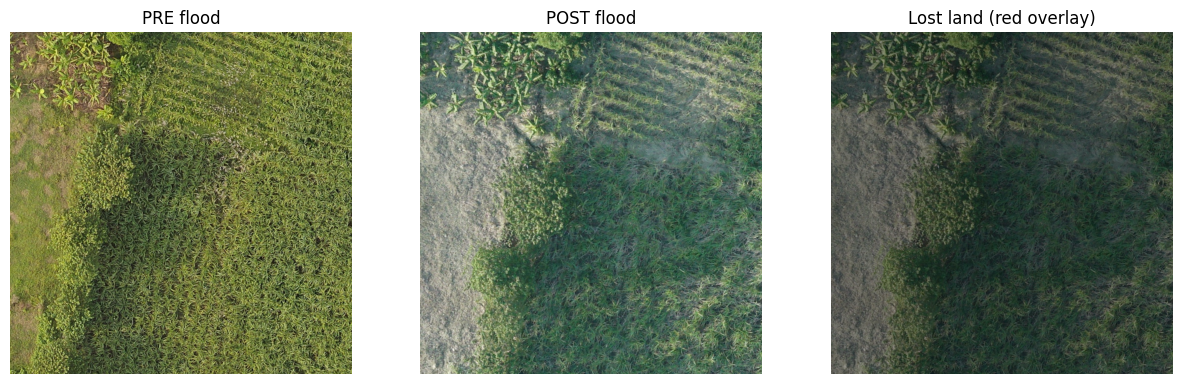

In [30]:
import matplotlib.pyplot as plt

def to_rgb(tile):
    rgb = tile[:3].astype("float32")
    valid = rgb > 0
    if valid.any():
        vmin = rgb[valid].min()
        vmax = rgb[valid].max()
        rgb = (rgb - vmin) / (vmax - vmin + 1e-6)
    else:
        rgb[:] = 0
    rgb = np.moveaxis(rgb, 0, -1)
    return rgb

rgb_pre = to_rgb(pre_tile)
rgb_post = to_rgb(post_tile)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(rgb_pre)
plt.title("PRE flood")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(rgb_post)
plt.title("POST flood")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(rgb_post)
# overlay lost_land in red
lost_land_vis = np.zeros_like(rgb_post)
lost_land_vis[..., 0] = lost_land_mask.astype("float32")  # red channel
lost_land_vis[..., 1] = 0
lost_land_vis[..., 2] = 0
alpha = 0.4
plt.imshow(lost_land_vis, alpha=alpha)
plt.title("Lost land (red overlay)")
plt.axis("off")

plt.show()


In [33]:
import os
import pandas as pd

pre_flood = "Hanumannagar_Preflood_Orthomosaic.tif"
post_flood = "Hanumannagar_Postflood_Orthomosaic.tif"

tile_size = 1024
github_handle = "Sazz-Sharma"


def compute_water_mask(tile, use_nir=True, ndwi_thresh=0.1, min_intensity=20):
    tile = tile.astype("float32")
    R = tile[0]
    G = tile[1]
    B = tile[2]

    if use_nir and tile.shape[0] >= 4:
        NIR = tile[3]
        ndwi = (G - NIR) / (G + NIR + 1e-6)
    else:
        ndwi = (G - R) / (G + R + 1e-6)

    intensity = (R + G + B) / 3.0
    water_mask = (ndwi > ndwi_thresh) & (intensity > min_intensity)
    return water_mask, ndwi


def to_rgb(tile):
    rgb = tile[:3].astype("float32")
    valid = rgb > 0
    if valid.any():
        vmin = rgb[valid].min()
        vmax = rgb[valid].max()
        rgb = (rgb - vmin) / (vmax - vmin + 1e-6)
    else:
        rgb[:] = 0
    # clip to [0, 1] to make matplotlib happy
    rgb = np.clip(rgb, 0.0, 1.0)
    rgb = np.moveaxis(rgb, 0, -1)  # (H, W, 3)
    return rgb


def save_rgb_png(tile, path):
    rgb = to_rgb(tile)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.imsave(path, rgb)

with rasterio.open(pre_flood) as src_pre, rasterio.open(post_flood) as src_post:
    # --- 1) pixel area (m²) from PRE transform ---
    transform_pre = src_pre.transform
    pixel_width = transform_pre[0]
    pixel_height = transform_pre[4]  # negative
    pixel_area_m2 = abs(pixel_width * pixel_height)
    print("Pixel area (m²):", pixel_area_m2)

    # --- 2) choose center tile in PRE ---
    W_pre, H_pre = src_pre.width, src_pre.height
    row_off_pre = H_pre // 2
    col_off_pre = W_pre // 2
    w_pre = min(tile_size, W_pre - col_off_pre)
    h_pre = min(tile_size, H_pre - row_off_pre)
    pre_window = Window(col_off_pre, row_off_pre, w_pre, h_pre)

    # bounds of this PRE tile (in EPSG:32645 meters)
    pre_bounds = rasterio.windows.bounds(pre_window, transform_pre)

    # --- 3) corresponding window in POST using same bounds ---
    post_window_float = rasterio.windows.from_bounds(
        *pre_bounds,
        transform=src_post.transform
    )
    post_window = Window(
        col_off=int(round(post_window_float.col_off)),
        row_off=int(round(post_window_float.row_off)),
        width=int(round(post_window_float.width)),
        height=int(round(post_window_float.height)),
    )

    # --- 4) read both tiles ---
    pre_tile = src_pre.read(window=pre_window)
    post_tile = src_post.read(window=post_window)

    # align shapes
    _, h_pre_t, w_pre_t = pre_tile.shape
    _, h_post_t, w_post_t = post_tile.shape
    h = min(h_pre_t, h_post_t)
    w = min(w_pre_t, w_post_t)
    pre_tile = pre_tile[:, :h, :w]
    post_tile = post_tile[:, :h, :w]

    print("Aligned tile shape:", pre_tile.shape, post_tile.shape)

    # --- 5) water masks in pre + post ---
    pre_water, _ = compute_water_mask(pre_tile, use_nir=True, ndwi_thresh=0.1, min_intensity=20)
    post_water, _ = compute_water_mask(post_tile, use_nir=True, ndwi_thresh=0.1, min_intensity=20)

    pre_land = ~pre_water
    lost_land_mask = pre_land & post_water

    lost_pixels = int(np.count_nonzero(lost_land_mask))
    print("Lost land pixels:", lost_pixels)

    # --- 6) compute areas ---
    land_pixels = int(np.count_nonzero(pre_land))
    area_m2 = land_pixels * pixel_area_m2          # total land area in this tile (pre)
    area_lost_m2 = lost_pixels * pixel_area_m2     # land -> water

    print("area_m2:", area_m2)
    print("area_lost_m2:", area_lost_m2)

    # --- 7) centroid of this tile (use PRE window center) ---
    # note: we use cropped height/width 'h' and 'w'
    row_center = row_off_pre + h / 2
    col_center = col_off_pre + w / 2

    x_center, y_center = rasterio.transform.xy(
        transform_pre,
        row_center,
        col_center,
        offset="center"
    )

    transformer = Transformer.from_crs(src_pre.crs, "EPSG:4326", always_xy=True)
    center_lon, center_lat = transformer.transform(x_center, y_center)

    print("Center lon/lat:", center_lon, center_lat)

    # --- 8) save cutout PNGs ---
    tile_id = "demo_tile_000"  # just a name for now

    pre_path = f"submissions/{github_handle}/cutouts/{tile_id}_pre.png"
    post_path = f"submissions/{github_handle}/cutouts/{tile_id}_post.png"

    save_rgb_png(pre_tile, pre_path)
    save_rgb_png(post_tile, post_path)

    print("Saved images:")
    print("  ", pre_path)
    print("  ", post_path)

    # --- 9) build one-row DataFrame like the final CSV ---
    row = {
        "tile_id": tile_id,
        "center_longitude": center_lon,
        "center_latitude": center_lat,
        "area_m2": area_m2,
        "area_lost_m2": area_lost_m2,
        "pre_flood_land_image": pre_path,
        "post_flood_land_image": post_path,
    }

    df = pd.DataFrame([row], columns=[
        "tile_id",
        "center_longitude",
        "center_latitude",
        "area_m2",
        "area_lost_m2",
        "pre_flood_land_image",
        "post_flood_land_image",
    ])

df


Pixel area (m²): 0.0018595500062500068
Aligned tile shape: (4, 1024, 1024) (4, 1024, 1024)
Lost land pixels: 0
area_m2: 1949.879507353607
area_lost_m2: 0.0
Center lon/lat: 86.90656117641177 26.558306023517396
Saved images:
   submissions/Sazz-Sharma/cutouts/demo_tile_000_pre.png
   submissions/Sazz-Sharma/cutouts/demo_tile_000_post.png


,tile_id,center_longitude,center_latitude,area_m2,area_lost_m2,pre_flood_land_image,post_flood_land_image
0,demo_tile_000,86.906561,26.558306,1949.879507,0.0,submissions/Sazz-Sharma/cutouts/demo_tile_000_...,submissions/Sazz-Sharma/cutouts/demo_tile_000_...


# Full Pipeline

In [34]:
import os
import math
import numpy as np
import rasterio
from rasterio.windows import Window
import rasterio.windows
import rasterio.transform
from pyproj import Transformer
import pandas as pd

pre_flood = "Hanumannagar_Preflood_Orthomosaic.tif"
post_flood = "Hanumannagar_Postflood_Orthomosaic.tif"

tile_size = 1024  # size of each tile in pixels
github_handle = "Sazz-Sharma"
min_lost_area_m2 = 100.0

rows = []

with rasterio.open(pre_flood) as src_pre, rasterio.open(post_flood) as src_post:
    transform_pre = src_pre.transform
    pixel_width = transform_pre[0]
    pixel_height = transform_pre[4]
    pixel_area_m2 = abs(pixel_width * pixel_height)
    print("Pixel area (m²):", pixel_area_m2)

    transformer = Transformer.from_crs(src_pre.crs, "EPSG:4326", always_xy=True)

    W_pre, H_pre = src_pre.width, src_pre.height
    n_cols = math.ceil(W_pre / tile_size)
    n_rows = math.ceil(H_pre / tile_size)
    print("Pre-flood size:", W_pre, H_pre)
    print("Tiling grid: rows =", n_rows, "cols =", n_cols)

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):
            col_off_pre = col_idx * tile_size
            row_off_pre = row_idx * tile_size
            w_pre = min(tile_size, W_pre - col_off_pre)
            h_pre = min(tile_size, H_pre - row_off_pre)

            if w_pre <= 0 or h_pre <= 0:
                continue

            pre_window = Window(col_off_pre, row_off_pre, w_pre, h_pre)

            pre_bounds = rasterio.windows.bounds(pre_window, transform_pre)

            post_window_float = rasterio.windows.from_bounds(
                *pre_bounds,
                transform=src_post.transform
            )

            post_window = Window(
                col_off=int(round(post_window_float.col_off)),
                row_off=int(round(post_window_float.row_off)),
                width=int(round(post_window_float.width)),
                height=int(round(post_window_float.height)),
            )

            if post_window.width <= 0 or post_window.height <= 0:
                continue

            try:
                pre_tile = src_pre.read(window=pre_window)
                post_tile = src_post.read(window=post_window)
            except Exception as e:
                continue

            _, h_pre_t, w_pre_t = pre_tile.shape
            _, h_post_t, w_post_t = post_tile.shape
            h = min(h_pre_t, h_post_t)
            w = min(w_pre_t, w_post_t)

            if h <= 0 or w <= 0:
                continue

            pre_tile = pre_tile[:, :h, :w]
            post_tile = post_tile[:, :h, :w]

            pre_water, _ = compute_water_mask(pre_tile, use_nir=True, ndwi_thresh=0.1, min_intensity=20)
            post_water, _ = compute_water_mask(post_tile, use_nir=True, ndwi_thresh=0.1, min_intensity=20)

            pre_land = ~pre_water
            lost_land_mask = pre_land & post_water

            lost_pixels = int(np.count_nonzero(lost_land_mask))
            if lost_pixels == 0:
                continue

            area_lost_m2 = lost_pixels * pixel_area_m2
            if area_lost_m2 < min_lost_area_m2:
                continue

            land_pixels = int(np.count_nonzero(pre_land))
            area_m2 = land_pixels * pixel_area_m2

            row_center = row_off_pre + h / 2
            col_center = col_off_pre + w / 2

            x_center, y_center = rasterio.transform.xy(
                transform_pre,
                row_center,
                col_center,
                offset="center"
            )
            center_lon, center_lat = transformer.transform(x_center, y_center)

            tile_id = f"tile_{row_idx:03d}_{col_idx:03d}"
            pre_path = f"flood-seg/submissions/{github_handle}/cutouts/{tile_id}_pre.png"
            post_path = f"flood-seg/submissions/{github_handle}/cutouts/{tile_id}_post.png"

            save_rgb_png(pre_tile, pre_path)
            save_rgb_png(post_tile, post_path)

            rows.append({
                "tile_id": tile_id,
                "center_longitude": center_lon,
                "center_latitude": center_lat,
                "area_m2": area_m2,
                "area_lost_m2": area_lost_m2,
                "pre_flood_land_image": pre_path,
                "post_flood_land_image": post_path,
            })

        print(f"Finished row {row_idx+1}/{n_rows}, rows collected so far: {len(rows)}")

df = pd.DataFrame(rows, columns=[
    "tile_id",
    "center_longitude",
    "center_latitude",
    "area_m2",
    "area_lost_m2",
    "pre_flood_land_image",
    "post_flood_land_image",
])

os.makedirs(f"flood-seg/submissions/{github_handle}", exist_ok=True)
csv_path = f"flood-seg/submissions/{github_handle}/affected.csv"
df.to_csv(csv_path, index=False)

print("Saved CSV at:", csv_path)
print("Total regions (tiles) with lost land:", len(df))

df.head()


Pixel area (m²): 0.0018595500062500068
Pre-flood size: 60971 88127
Tiling grid: rows = 87 cols = 60
Finished row 1/87, rows collected so far: 0
Finished row 2/87, rows collected so far: 6
Finished row 3/87, rows collected so far: 12
Finished row 4/87, rows collected so far: 14
Finished row 5/87, rows collected so far: 18
Finished row 6/87, rows collected so far: 21
Finished row 7/87, rows collected so far: 24
Finished row 8/87, rows collected so far: 28
Finished row 9/87, rows collected so far: 32
Finished row 10/87, rows collected so far: 35
Finished row 11/87, rows collected so far: 40
Finished row 12/87, rows collected so far: 46
Finished row 13/87, rows collected so far: 54
Finished row 14/87, rows collected so far: 61
Finished row 15/87, rows collected so far: 66
Finished row 16/87, rows collected so far: 68
Finished row 17/87, rows collected so far: 68
Finished row 18/87, rows collected so far: 68
Finished row 19/87, rows collected so far: 68
Finished row 20/87, rows collected so

,tile_id,center_longitude,center_latitude,area_m2,area_lost_m2,pre_flood_land_image,post_flood_land_image
0,tile_001_035,86.908866,26.575065,435.930589,435.930589,flood-seg/submissions/Sazz-Sharma/cutouts/tile...,flood-seg/submissions/Sazz-Sharma/cutouts/tile...
1,tile_001_036,86.909310,26.575065,1949.879507,1881.323477,flood-seg/submissions/Sazz-Sharma/cutouts/tile...,flood-seg/submissions/Sazz-Sharma/cutouts/tile...
2,tile_001_037,86.909753,26.575066,1941.007594,1193.816228,flood-seg/submissions/Sazz-Sharma/cutouts/tile...,flood-seg/submissions/Sazz-Sharma/cutouts/tile...
3,tile_001_038,86.910197,26.575066,1227.448049,1227.448049,flood-seg/submissions/Sazz-Sharma/cutouts/tile...,flood-seg/submissions/Sazz-Sharma/cutouts/tile...
4,tile_001_039,86.910640,26.575066,547.274865,547.274865,flood-seg/submissions/Sazz-Sharma/cutouts/tile...,flood-seg/submissions/Sazz-Sharma/cutouts/tile...
